In [26]:
import pandas as pd
import numpy as np
import time
from memory_profiler import memory_usage
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv" #reading the file
df = pd.read_csv(url,index_col=0)
df.head()
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [27]:
#Q1
pd.isnull(df).sum()[pd.isnull(df).sum() > 0] #finding the cols with NaN values and the number of NaN values in each col

storage_type      42
gpu             1371
screen             4
dtype: int64

In [28]:
df.dtypes

status           object
brand            object
model            object
cpu              object
ram               int64
storage           int64
storage_type     object
gpu              object
screen          float64
touch            object
final_price     float64
dtype: object

In [29]:
strings = list(df.dtypes[(df.dtypes == 'int64')|(df.dtypes == 'float64')].index)
strings

['ram', 'storage', 'screen', 'final_price']

In [30]:
df=df[strings]

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='final_price', ylabel='Count'>

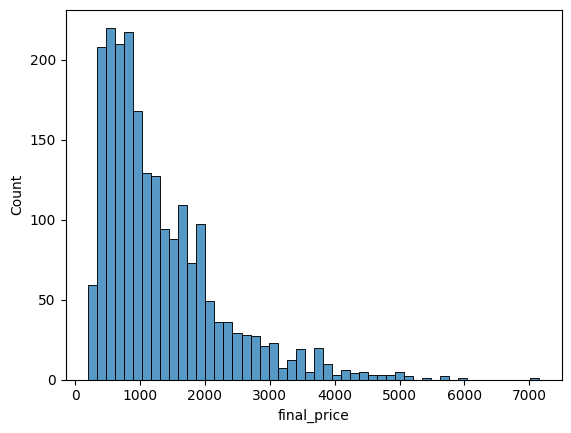

In [32]:
sns.histplot(df.final_price, bins=50)

In [33]:
#Q2
df.ram.median()

16.0

In [34]:
screen_mean=df.screen.mean()
print(screen_mean)

15.168112244897959


In [35]:
#Splliting the dataset in train val and test
def split_data(df,seed):
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    df_train = df.iloc[:n_train]
    df_val = df.iloc[n_train:n_train+n_val]
    df_test = df.iloc[n_train+n_val:]

    idx = np.arange(n)

    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.final_price.values)
    y_val = np.log1p(df_val.final_price.values)
    y_test = np.log1p(df_test.final_price.values)

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    return df_train,df_val,df_test,y_train,y_val,y_test

In [36]:
start_time = time.time()
mem_usage_before = memory_usage()[0]

In [37]:
#Splliting the dataset in train val and test
def split_data_without_log1(df,seed):
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    df_train = df.iloc[:n_train]
    df_val = df.iloc[n_train:n_train+n_val]
    df_test = df.iloc[n_train+n_val:]

    idx = np.arange(n)

    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    return df_train,df_val,df_test,y_train,y_val,y_test

In [38]:
end_time = time.time()
mem_usage_after = memory_usage()[0]
execution_time = end_time - start_time
memory_used = mem_usage_after - mem_usage_before
print(f"Function executed in: {execution_time:.6f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

Function executed in: 0.403903 seconds
Memory used: 0.01 MB


In [39]:
def prepare_X(df):
    df = df.fillna(0)
    X = df.values
    return X

def prepare_X_mean(df):
    df = df.fillna(screen_mean)
    X = df.values
    return X

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [40]:
#Q3 with NaN replaced with 0 and seed 42
df_train,df_val,df_test,y_train,y_val,y_test=split_data(df,42)
x_train=prepare_X(df_train)
x_val=prepare_X(df_val)
w0,w=train_linear_regression(x_train,y_train)
y_prdt=w0+x_val.dot(w)
score=rmse(y_val,y_prdt)
print(round(score,2))

0.43


In [41]:
#Q3 with NaN replaced with mean of screen and seed 42
df_train,df_val,df_test,y_train,y_val,y_test=split_data(df,42)
x_train=prepare_X_mean(df_train)
x_val=prepare_X(df_val)
w0,w=train_linear_regression(x_train,y_train)
y_prdt=w0+x_val.dot(w)
score=rmse(y_val,y_prdt)
print(round(score,2))

0.43


In [42]:
#code for regularization
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [43]:
#Q4
r=[0, 0.01, 0.1, 1, 5, 10, 100]
for r in r:
    df_train,df_val,df_test,y_train,y_val,y_test=split_data(df,42)
    x_train=prepare_X(df_train)
    x_val=prepare_X(df_val)
    w0,w=train_linear_regression_reg(x_train,y_train,r)
    y_prdt=w0+x_val.dot(w)
    score=rmse(y_val,y_prdt)
    print(f'for the {r} erorr is',round(score,2))


for the 0 erorr is 0.43
for the 0.01 erorr is 0.43
for the 0.1 erorr is 0.43
for the 1 erorr is 0.43
for the 5 erorr is 0.46
for the 10 erorr is 0.51
for the 100 erorr is 0.67


In [44]:
#Q5 
seed_vals=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_vals=[]
for s in seed_vals:
    df_train,df_val,df_test,y_train,y_val,y_test=split_data_without_log1(df,s)
    x_train=prepare_X(df_train)
    x_val=prepare_X(df_val)
    w0,w=train_linear_regression(x_train,y_train)
    y_prdt=w0+x_val.dot(w)
    score=rmse(y_val,y_prdt)
    rmse_vals.append(score)
    print(f'for the seed {s} erorr is',round(score,2))

print('std of all rmse is',round(np.std(rmse_vals),3))

for the seed 0 erorr is 565.45
for the seed 1 erorr is 636.8
for the seed 2 erorr is 588.96
for the seed 3 erorr is 597.81
for the seed 4 erorr is 571.96
for the seed 5 erorr is 573.24
for the seed 6 erorr is 647.34
for the seed 7 erorr is 550.44
for the seed 8 erorr is 587.33
for the seed 9 erorr is 576.1
std of all rmse is 29.176


In [45]:
 #Q6
n = len(df)
n_test = int(n * 0.2)
n_train_val = n -  n_test

df_train = df.iloc[:n_train_val]
df_test = df.iloc[n_train_val:]

idx = np.arange(n)

np.random.seed(9)
np.random.shuffle(idx)

df_train_val = df.iloc[idx[:n_train_val]]
df_test = df.iloc[idx[n_train_val:]]

df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_val = df_train_val.final_price.values
y_test = df_test.final_price.values

del df_train_val['final_price']
del df_test['final_price']

x_train_val=prepare_X(df_train_val)
x_test=prepare_X(df_test)
w0,w= train_linear_regression_reg(x_train_val,y_train_val,r=0.001)
y_prdt= w0 + x_test.dot(w)
print('RSME score is',round(rmse(y_test,y_prdt),2))


RSME score is 608.61
